In [1]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os
import numpy as np

In [2]:
import pylab as plt
plt.rcParams.update({"axes.grid" : True})
plt.rcParams.update({'font.size': 12})

In [3]:
from twpazer.freader import file2dic, dic2file

In [4]:
def dump(d, Ztarget, Z, l, L, C, w, Lk, islabel=True):
    labels = ['d' , 'Z0target', 'Z0' ,   'l'   , 'L'   , 'C'   , 'Lk',      'nsq', 'Lf', 'Cf']
    units  = ['nm', '[Ohm]'   , '[Ohm]', '[um]', '[pH]', '[fF]', '[pH/sq]', ''   , 'nH', '[fF]'] 
    
    nsq = l/w     # number of square per finger
    Lf  = Lk*nsq  # finger inductance to ground (Malnou's model)
    Cf  = C/2     # finger capacitance to ground (Malnou's model)
    
    formatter=''.join(['%-11s']*len(labels))
    
    restarget=[a*b for a,b in zip([d, Ztarget, Z, l ,L, C, Lk, nsq, Lf, Cf], 
                                  [1, 1, 1, 1, 1e12, 1e15, 1e12, 1, 1e9, 1e15])]
    

    if islabel:
        print (formatter%tuple(labels))
        print (formatter%tuple(units))
        print('-' * 110)
    print (formatter%tuple(["%.2f" % i for i in restarget]))
        
    return

In [5]:
Z0fun = lambda L, C : np.sqrt(L/C)

In [6]:
def check_number(s):
    try: 
        float(s)
        return True
    except ValueError:
        return False

In [7]:
def create_path(Lk, e, d, basepath):
        
    filepath = os.path.join(basepath,    
                            'Lk{Lk}_eps{e:.1f}_d{d}'.format(Lk=Lk, e=e, d=d), 
                            'savepath')
        
    return os.path.join(filepath, [d for d in os.listdir(filepath) if 'reduced' in d][0])

In [8]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

### Plot as a function of the finger length

In [9]:
(Lk, eps, d) = (30, 9.1, 100)

basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

filename = os.path.join('Lk{Lk}_eps{e}_d{d}'.format(Lk=Lk, e=eps, d=d),
                        'savepath',
                        'Lk{Lk}_t10_w1_s1_d{d}_eps{e}_all_results.h5'.format(Lk=Lk,e=eps, d=d))


In [10]:
ldata=file2dic(os.path.join(basepath, filename), writer='h5').read()

In [11]:
ldata['1.0']['Z'].keys()

dict_keys(['Z', 'Z0', 'Zfit', 'freq', 'freq_fit', 'p'])

In [12]:
ls=sorted([float(x) for x in ldata.keys() if check_number(x)])

In [13]:
from matplotlib import cm, colors
cmap   = plt.cm.turbo_r
cols   = get_colors(ls, cmap, 
                    vmin=np.min(ls), vmax=np.max(ls))
cols   = dict(zip(reversed(ls), cols))

<IPython.core.display.Javascript object>


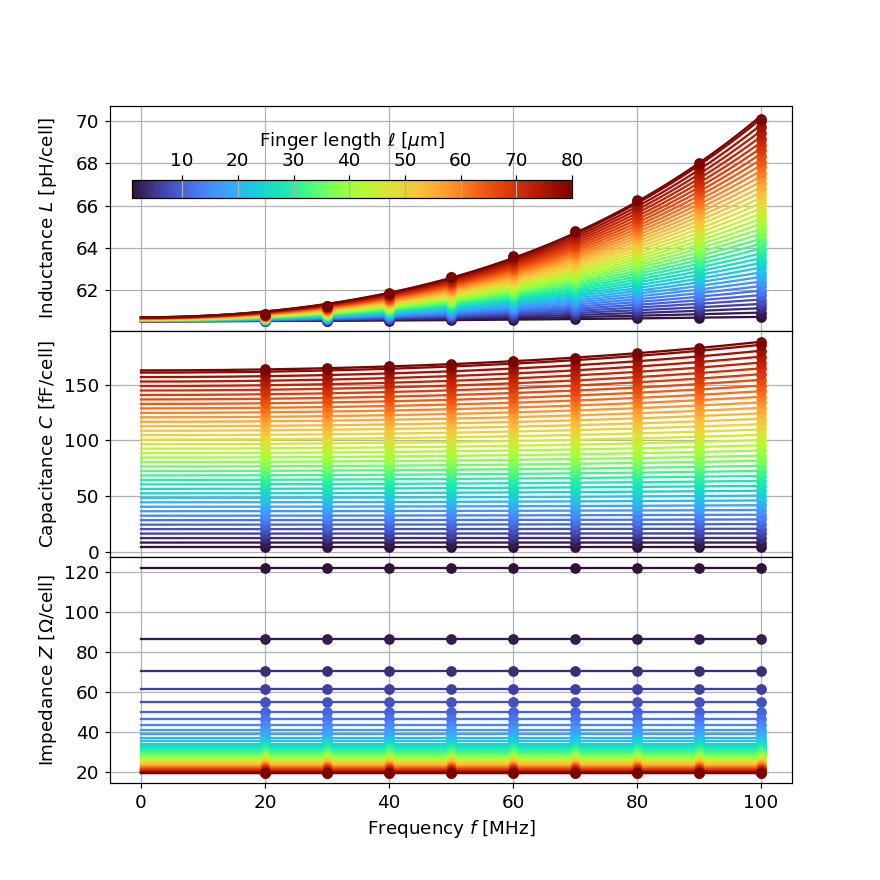

Text(0.5, 0, 'Finger length $\\ell$ [$\\mu$m]')

In [14]:
fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for l in ls:
    
    ax[0].plot(ldata[str(l)]['L']['freq']/1e6, ldata[str(l)]['L']['L']/1e-12,                     
               marker='o', ls='none', color=cols[l])
    ax[0].plot(ldata[str(l)]['L']['freq_fit']/1e6, ldata[str(l)]['L']['Lfit']/1e-12,                      
               color=ax[0].lines[-1].get_color())
    
    ax[1].plot(ldata[str(l)]['C']['freq']/1e6, ldata[str(l)]['C']['C']/1e-15,                     
               marker='o', ls='none', color=cols[l])
    ax[1].plot(ldata[str(l)]['C']['freq_fit']/1e6, ldata[str(l)]['C']['Cfit']/1e-15,                      
               color=ax[0].lines[-1].get_color())
    
    
    ax[2].plot(ldata[str(l)]['Z']['freq']/1e6, ldata[str(l)]['Z']['Z'],                     
               marker='o', ls='none', color=cols[l])
    ax[2].plot(ldata[str(l)]['Z']['freq_fit']/1e6, ldata[str(l)]['Z']['Zfit'],                      
               color=ax[0].lines[-1].get_color())
    
        
#ylabels=['Inductance $\\mathcal{L}$ [pH/cell]', 'Capacitance $\\mathcal{C}$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
ylabels=['Inductance $L$ [pH/cell]', 'Capacitance $C$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
  
    
for i in [0,1,2]:    
         
    if i == 2:
        ax[i].set_xlabel('Frequency $f$ [MHz]')
    
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
    
    ax[i].get_yaxis().set_label_coords(-0.075,0.5)
    
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.15, 0.775, 0.5, 0.02])

#cbar=m.colorbar(trend, size='3%',ticks=bounds,extend="max",location="bottom")

fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(ls),                                                 
                                                     np.max(ls)), cmap=cmap.reversed()),                  
             ax=ax[1], cax=cbar_ax, orientation="horizontal")
    
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xlabel('Finger length $\ell$ [$\mu$m]')


In [15]:
for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_vs_ell_and_f'+e),
                      bbox_inches='tight', transparent=True)

### Analysis as function of thickness

In [16]:
basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

In [17]:
ds  = [100, 200, 300, 400]

colors=["#003049","#d62828","#f77f00","#fcbf49","#eae2b7"]
colors = dict(zip(ds, colors))

(eps, Lk) = (9.1, 30)

In [18]:
colors

{100: '#003049', 200: '#d62828', 300: '#f77f00', 400: '#fcbf49'}

<IPython.core.display.Javascript object>


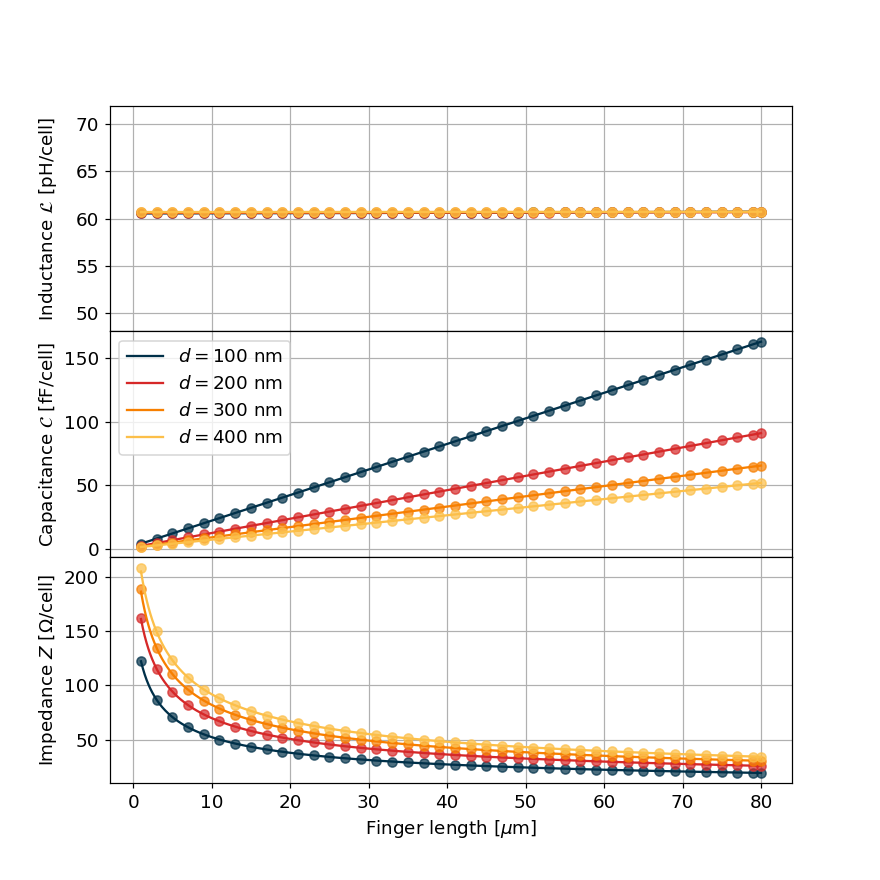

60.62249985150546
60.63082068397932
60.66809607154358
60.704754996253534


In [27]:
resdata=dict()

resdata.setdefault('data',{})

fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for d in ds:
    
    filename = create_path(Lk, eps, d, basepath)    
    resdata['data'].setdefault(d, {})
    resdata['data'][d] = file2dic(filename, writer='h5').read()
    
    resdata['data'][d].update({'Z'   : Z0fun(resdata['data'][d]['L'],    resdata['data'][d]['C']),                                                                                                   
                               'Zfit': Z0fun(resdata['data'][d]['Lfit'], resdata['data'][d]['Cfit'])})
    
    ax[0].plot(resdata['data'][d]['l'], resdata['data'][d]['L']*1e12, marker = 'o', ls='none',     
                 alpha=0.7, color=colors[d])
    ax[0].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Lfit']*1e12, marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    ax[0].set_ylim([48, 72])
    
    print(np.mean(resdata['data'][d]['L'])*1e12)
    
    ax[1].plot(resdata['data'][d]['l'], resdata['data'][d]['C']*1e15, marker = 'o', ls='none',     
                 alpha=0.7, color=colors[d])
    ax[1].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Cfit']*1e15, marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color(), label='$d={d}$ nm'.format(d=d))
    
    
    ax[2].plot(resdata['data'][d]['l'], resdata['data'][d]['Z'], marker = 'o', ls='none',     
                 alpha=0.7, color=colors[d])
    ax[2].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Zfit'], marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    
    


ylabels=['Inductance $\\mathcal{L}$ [pH/cell]', 'Capacitance $\\mathcal{C}$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
    
for i in [0,1,2]:    
    
    if i == 0: 
        pass
        #ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
    
    if i == 1: 
        ax[i].legend(loc='upper left')
        
    if i == 2:
        ax[i].set_xlabel('Finger length [$\\mu$m]')
    
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
   
    ax[i].get_yaxis().set_label_coords(-0.075,0.5)


In [21]:
Zarget = [78, 48]
for Z0target in Zarget:
    ax[2].axhline(y=Z0target, color='black', lw=0.9, ls='--')    
    xtext=ax[2].get_xlim()[1]-0.20*(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])    
    ax[2].text(xtext, Z0target+5, r'$Z_0 = {Z}\,\Omega$'.format(Z=Z0target))

In [22]:
resdata.setdefault('lbest',{})
Zarget = [78, 48]
resdata['lbest'].update({Z: {'l': list(), 'L': list(), 'C': list(), 'Z': list(), 'd': list(),}  for Z in Zarget })   

for d in resdata['data']: 
    for Z in Zarget:
        resdata['lbest'][Z]['d'].append(d)
        idx=np.argmin(np.abs(Z-resdata['data'][d]['Zfit']))
        resdata['lbest'][Z]['Z'].append(resdata['data'][d]['Zfit'][idx])
        resdata['lbest'][Z]['C'].append(resdata['data'][d]['Cfit'][idx])
        resdata['lbest'][Z]['L'].append(resdata['data'][d]['Lfit'][idx])
        resdata['lbest'][Z]['l'].append(resdata['data'][d]['lfit'][idx])

for Z in Zarget:
    for x in ['d', 'Z', 'C', 'L', 'l']:
        resdata['lbest'][Z][x]=np.array(resdata['lbest'][Z][x])
    

In [23]:
for Z in Zarget:
    ax[2].plot(resdata['lbest'][Z]['l'],             
               resdata['lbest'][Z]['Z'],                                 
               marker='o', ls='none', color='k', zorder=100)
    
for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_ell_vs_d'+e),
                      bbox_inches='tight', transparent=True)


<IPython.core.display.Javascript object>


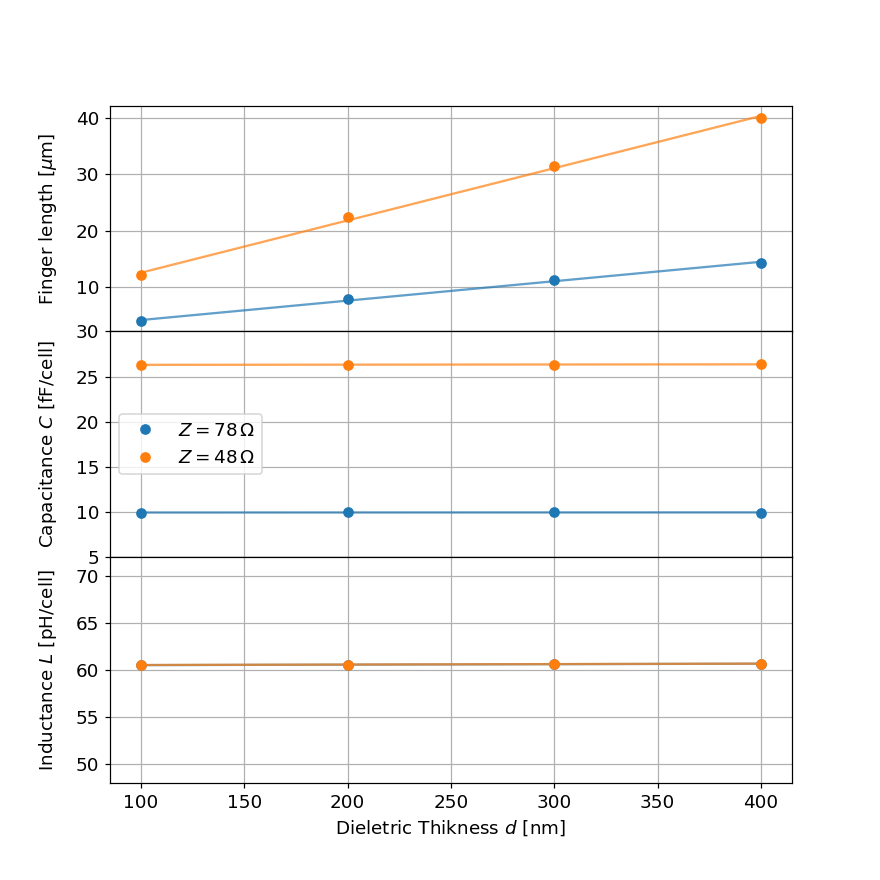

 
0.03448 x + 0.6837
 
0.09284 x + 3.254


In [24]:
fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for Z in resdata['lbest']:
    ax[0].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['l'], marker='o', ls='none',                                       
               label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['l'], 1))
    ax[0].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d']),                               
               color=ax[0].lines[-1].get_color(), alpha=0.7)
        
    print(p)
    resdata['lbest'][Z]['pl']=[p.coef[0], p.coef[1]]
     
    
    ax[1].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['C']*1e15, marker='o', ls='none',                              
             label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['C'], 1))
    ax[1].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d'])*1e15,                              
               color=ax[1].lines[-1].get_color(), alpha=0.7)
        
    ax[1].set_ylim([5, 30])
    
    resdata['lbest'][Z]['pC']=[p.coef[0], p.coef[1]]
    
    
    ax[2].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['L']*1e12, marker='o', ls='none',                                           
               label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['L'], 1))
    ax[2].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d'])*1e12,                      
               color=ax[2].lines[-1].get_color(), alpha=0.7)
    
    ax[2].set_ylim([48, 72])
    
    resdata['lbest'][Z]['pL']=[p.coef[0], p.coef[1]]
       
    

ylabels=['Finger length [$\\mu$m]', 'Capacitance $C$ [fF/cell]', 'Inductance $L$ [pH/cell]']
    
for i in [0,1,2]:    
    
    if i == 0: 
        pass
        #ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
    
    if i == 1: 
        ax[i].legend(loc='center left')
    
    if  i == 2:
        ax[i].set_xlabel('Dieletric Thikness $d$ [nm]')
    
        
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
    
    ax[i].get_yaxis().set_label_coords(-0.075,0.5)
    
    #print(p)
    #print(Z, p.coef[0], p.coef[1])
    
#plt.ylabel('Finger length $\ell$ [$\\mu$m]')
#plt.xlabel('Dieletric Thickness $d$ [nm]')
#plt.legend(loc="upper left")


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_Z_and_ell_vs_d'+e),
                      bbox_inches='tight', transparent=True)

In [26]:
Zarget = [78, 48]
w  = 1    # finger width

islabel=True
for d in resdata['data']:    
    for Z in Zarget:
        idx=np.argmin(np.abs(Z-resdata['data'][d]['Zfit']))
        dump(d, Z,              
            resdata['data'][d]['Zfit'][idx], 
            resdata['data'][d]['lfit'][idx],              
            resdata['data'][d]['Lfit'][idx],             
            resdata['data'][d]['Cfit'][idx],              
            w, Lk*1e-12, islabel)
        islabel=False

d          Z0target   Z0         l          L          C          Lk         nsq        Lf         Cf         
nm         [Ohm]      [Ohm]      [um]       [pH]       [fF]       [pH/sq]               nH         [fF]       
--------------------------------------------------------------------------------------------------------------
100.00     78.00      78.02      3.93       60.54      9.95       30.00      3.93       0.12       4.97       
100.00     48.00      47.97      12.07      60.56      26.32      30.00      12.07      0.36       13.16      
200.00     78.00      77.93      7.80       60.60      9.98       30.00      7.80       0.23       4.99       
200.00     48.00      47.99      22.35      60.61      26.31      30.00      22.35      0.67       13.16      
300.00     78.00      77.89      11.20      60.65      10.00      30.00      11.20      0.34       5.00       
300.00     48.00      47.99      31.45      60.66      26.34      30.00      31.45      0.94       13.17      
4

In [27]:
for Z in Zarget:    
    print(Z, resdata['lbest'][Z]['pl'][0], resdata['lbest'][Z]['pl'][1])  
    

78 0.034478478478478465 0.6836836836836836
48 0.09283883883883884 3.25375375375374


In [54]:
Nu=30;   Nl=4
Lu=60.6/1e12; Ll=60.6/1e12
Cu=26.4/1e15; Cl=10.0/1e15; 

In [55]:
Zeff=np.sqrt( (Nu*Lu+Nl*Ll)/(Nu*Cu+Nl*Cl) )

In [56]:
Zeff

49.763865481816296